In [147]:
import pandas as pd
import numpy as np

import seaborn as sns
import networkx as nx
from matplotlib import pyplot as plt
import altair as alt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.base import clone





from prettytable import PrettyTable, TableStyle
import joblib


In [249]:
random_state=22

# Load data, perform imputation and train test split

In [250]:
def load_data(option: str = "1985-2023") -> pd.DataFrame:
    df = pd.DataFrame()
    if option == "1985-2023":
        df = pd.read_excel("../data/tentative_final_with_NaN.xlsx")
    if option == "2010-2023":
        df = pd.read_excel("../data/tentative_final.xlsx")
    return df

tentative_df = load_data()

In [251]:
tentative_df["social_vs_security"]=(tentative_df['adj_education_budget']+tentative_df['adj_welfare_budget']+tentative_df['adj_health_budget'])/(tentative_df['adj_police_budget']+tentative_df['adj_judiciary_budget']+tentative_df['adj_prison_budget'])
tentative_df["security_vs_social"]=(tentative_df['adj_police_budget']+tentative_df['adj_judiciary_budget']+tentative_df['adj_prison_budget'])/(tentative_df['adj_education_budget']+tentative_df['adj_welfare_budget']+tentative_df['adj_health_budget'])
feature_0=['Population','clearance_rate',
       'population_density', 'unemployment_rate', 'adjusted_income',
       'poverty_rate', 'rent_burden', 'home_ownership_rate',
       'mobile_home_ratio', 'vacancy_rate', 'Number_of_Persons_per_HseHld',
       'renter_ratio',
       'median_age', 'adj_police_budget',
       'adj_education_budget', 'adj_welfare_budget',
       'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget',
       'adj_judiciary_budget', 'adj_prison_budget',
       #'median_house_value',
       'house_affordability', 'uninsured_rate',
       'high_school_rate', 'dropout_rate', 'public_school_rate',
        "social_vs_security", "security_vs_social"] #'adherent_rate', 'rdm',
feature_cat=['Category_Rural', 'Category_Suburban', 'Category_Urban']
crime_dataframe=tentative_df[['County', 'Year',  'crime_rate']+feature_0+feature_cat]
crime_dataframe=crime_dataframe.set_index(['County', 'Year'])
crime_dataframe.head()

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 1985    0.009809     1185500        0.466890         1606.368564   
        1986    0.010353     1206900        0.445778         1635.365854   
        1987    0.009588     1220600        0.538580         1653.929539   
        1988    0.008825     1242300        0.520660         1683.333333   
        1989    0.008375     1261200        0.497018         1708.943089   

              unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County  Year                                                                  
Alameda 1985                NaN              NaN           NaN          NaN   
        1986                NaN              NaN           NaN          NaN   
        1987                NaN              NaN           NaN          NaN   
        1988                NaN              NaN           NaN          NaN   
        1989                NaN              NaN           NaN          NaN   

              home_ownership_rate  mobile_home_ratio  ...  \
County  Year                                          ...   
Alameda 1985                  NaN                NaN  ...   
        1986                  NaN                NaN  ...   
        1987                  NaN                NaN  ...   
        1988                  NaN                NaN  ...   
        1989                  NaN                NaN  ...   

              house_affordability  uninsured_rate  high_school_rate  \
County  Year                                                          
Alameda 1985                  NaN             NaN               NaN   
        1986                  NaN             NaN               NaN   
        1987                  NaN             NaN               NaN   
        1988                  NaN             NaN               NaN   
        1989                  NaN             NaN               NaN   

              dropout_rate  public_school_rate  social_vs_security  \
County  Year                                                         
Alameda 1985           NaN                 NaN                 NaN   
        1986           NaN                 NaN                 NaN   
        1987           NaN                 NaN                 NaN   
        1988           NaN                 NaN                 NaN   
        1989           NaN                 NaN                 NaN   

              security_vs_social  Category_Rural  Category_Suburban  \
County  Year                                                          
Alameda 1985                 NaN               0                  0   
        1986                 NaN               0                  0   
        1987                 NaN               0                  0   
        1988                 NaN               0                  0   
        1989                 NaN               0                  0   

              Category_Urban  
County  Year                  
Alameda 1985               1  
        1986               1  
        1987               1  
        1988               1  
        1989               1  

[5 rows x 32 columns]

In [252]:
crime_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2262 entries, ('Alameda', 1985) to ('Yuba', 2023)
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   crime_rate                    2262 non-null   float64
 1   Population                    2262 non-null   int64  
 2   clearance_rate                2262 non-null   float64
 3   population_density            2262 non-null   float64
 4   unemployment_rate             1914 non-null   float64
 5   adjusted_income               928 non-null    float64
 6   poverty_rate                  870 non-null    float64
 7   rent_burden                   812 non-null    float64
 8   home_ownership_rate           812 non-null    float64
 9   mobile_home_ratio             812 non-null    float64
 10  vacancy_rate                  812 non-null    float64
 11  Number_of_Persons_per_HseHld  812 non-null    float64
 12  renter_ratio                  812 no

In [253]:
Final={}
Final["dropna"]=crime_dataframe.dropna()
Final["dropna"].shape

(624, 32)

Imputation

In [254]:
# 1. Copy your original DataFrame and set a MultiIndex
df = crime_dataframe.copy()
#df = df.set_index(['County', 'Year'])

def fill_missing_with_linear_regression(group):
    """
    For a single county (group), fit a simple linear regression model
    Year vs. each numeric column. Use that model to fill missing values.
    """
    # Sort by Year for clarity
    group = group.sort_index(level='Year')
    
    # Iterate over each column
    for col in group.columns:
        # Only process numeric columns
        if pd.api.types.is_numeric_dtype(group[col]):
            # Extract the known data points (drop missing)
            valid_data = group[col].dropna()
            
            # If there aren't at least two valid points, we can't fit a regression
            if len(valid_data) < 2:
                continue
            
            # Prepare X (Year) and y (column values)
            X = valid_data.index.get_level_values('Year').values.reshape(-1, 1)
            y = valid_data.values
            
            # Fit the linear regression model
            model = LinearRegression().fit(X, y)
            
            # Predict for all years in this county
            X_all = group.index.get_level_values('Year').values.reshape(-1, 1)
            y_pred = model.predict(X_all)
            
            # Fill only missing values with the predictions
            missing_mask = group[col].isna()
            group.loc[missing_mask, col] = y_pred[missing_mask]
        else:
            print(f"Skipping non-numeric column: {col}")
    
    return group

# 2. Group by County and apply the regression-based filling
df_reg_filled = (
    df.groupby(level='County', group_keys=False)
      .apply(fill_missing_with_linear_regression)
)

#df_reg_filled.head()

In [255]:
final_dataframe = df_reg_filled
#print(final_dataframe.isna().sum())
print(final_dataframe.shape)
final_dataframe=final_dataframe.dropna()
print(final_dataframe.shape)
Final["imputed"]=final_dataframe

(2262, 32)
(2108, 32)


In [256]:
print(np.var(final_dataframe['crime_rate']))
# Group by county and compute the variance of crime_rate for each county,
# then compute the average variance across all counties.
county_variances = final_dataframe.groupby(level="County")["crime_rate"].var()
avg_county_variance = county_variances.mean()
print("Average variance of crime_rate by county:", avg_county_variance)

# Group by year and compute the variance of crime_rate for each year,
# then compute the average variance across all years.
year_variances = final_dataframe.groupby(level="Year")["crime_rate"].var()
avg_year_variance = year_variances.mean()
print("Average variance of crime_rate by year:", avg_year_variance)


6.163726529166426e-06
Average variance of crime_rate by county: 3.7796157807726586e-06
Average variance of crime_rate by year: 5.260953083223783e-06


In [257]:
def Poly_df_function(df0):
    poly = PolynomialFeatures(degree=2, include_bias=False)
    Poly_data = poly.fit_transform(df0)
    feature_names = poly.get_feature_names_out(input_features=df0.columns)
    Poly_df = pd.DataFrame(Poly_data, columns=feature_names, index=df0.index)
    return Poly_df

In [258]:
# Initialize the dictionaries.
X_train_dt = {}
X_test_dt = {}
y_train_dt = {}
y_test_dt = {}
X_train_Poly_dt = {}
X_test_Poly_dt = {}

X_train_log_dt = {}
X_test_log_dt = {}
X_train_Poly_log_dt = {}
X_test_Poly_log_dt = {}
y_train_clean_dt = {}
y_test_clean_dt = {}

# Iterate over the keys and the different categories.
for key in Final.keys():
    for key1 in ["All", "Urban", "Suburban", "Rural"]:
        if key1 == "All":
            df = Final[key]
        else:
            df = Final[key][Final[key]["Category_" + key1] == 1]

        # Split the data into features (using feature_0 columns) and target ("crime_rate").
        X = df[feature_0]
        y = df["crime_rate"]
        PolyX = Poly_df_function(X)
        
        # Split the data into training and testing sets for the original data.
        X_train, X_test, y_train, y_test, X_train_Poly, X_test_Poly = train_test_split(
            X, y, PolyX, test_size=0.15, random_state=random_state, shuffle=True
        )
        
        # Store original splits.
        X_train_dt[(key, key1)] = X_train
        X_test_dt[(key, key1)] = X_test
        y_train_dt[(key, key1)] = y_train
        y_test_dt[(key, key1)] = y_test
        X_train_Poly_dt[(key, key1)] = X_train_Poly
        X_test_Poly_dt[(key, key1)] = X_test_Poly

        # Create a log-transformed version.
        # Drop rows with nonpositive entries in any of the base features.
        X_clean = X[(X > 0).all(axis=1)].copy()
        for col in feature_0:
            X_clean["log_" + col] = np.log(X_clean[col])
        
        # Use only rows with valid log-transformed values.
        y_clean = y.loc[X_clean.index]
        
        # Split the log-data into training and testing sets.
        X_train_log, X_test_log, y_train_clean, y_test_clean = train_test_split(
            X_clean, y_clean, test_size=0.15, random_state=random_state, shuffle=True
        )
        
        # Instead of applying Poly_df_function to the entire X_train_log,
        # we keep the polynomial features from the original split and add the log columns for feature_0.
        X_train_Poly_log = X_train_Poly.copy()
        X_test_Poly_log = X_test_Poly.copy()
        for col in feature_0:
            # Note: X_train_log already contains the log-transformed column named "log_" + col.
            X_train_Poly_log["log_" + col] = X_train_log["log_" + col]
            X_test_Poly_log["log_" + col] = X_test_log["log_" + col]
        
        # Store the log-splits in the new dictionaries.
        X_train_log_dt[(key, key1)] = X_train_log
        X_test_log_dt[(key, key1)] = X_test_log
        X_train_Poly_log_dt[(key, key1)] = X_train_Poly_log
        X_test_Poly_log_dt[(key, key1)] = X_test_Poly_log
        y_train_clean_dt[(key, key1)] = y_train_clean
        y_test_clean_dt[(key, key1)] = y_test_clean


In [259]:
#Not using this

def train_test_split_by_county(X, y, X_poly, test_size=0.15, random_state=random_state):
    # Extract unique counties from the MultiIndex (assumed to have level "County")
    counties = np.array(X.index.get_level_values("County").unique())
    np.random.seed(random_state)
    
    # Shuffle and split counties
    n_counties = len(counties)
    n_test = int(np.floor(test_size * n_counties))
    shuffled = np.random.permutation(counties)
    test_counties = shuffled[:n_test]
    train_counties = shuffled[n_test:]
    
    # Create masks for train and test based on counties
    train_mask = X.index.get_level_values("County").isin(train_counties)
    test_mask = X.index.get_level_values("County").isin(test_counties)
    
    # Subset the data using the masks
    X_train = X[train_mask]
    X_test  = X[test_mask]
    y_train = y[train_mask]
    y_test  = y[test_mask]
    X_poly_train = X_poly[train_mask]
    X_poly_test  = X_poly[test_mask]
    
    return X_train, X_test, y_train, y_test, X_poly_train, X_poly_test

# Now apply the function for each dataset:
#X_train_Urban, X_test_Urban, y_train_Urban, y_test_Urban, X_train_Poly_Urban, X_test_Poly_Urban = train_test_split_by_county(
#    X_Urban, y_Urban, X_Poly_Urban, test_size=0.15, random_state=42
#)

#X_train_Suburban, X_test_Suburban, y_train_Suburban, y_test_Suburban, X_train_Poly_Suburban, X_test_Poly_Suburban = train_test_split_by_county(
#    X_Suburban, y_Suburban, X_Poly_Suburban, test_size=0.15, random_state=42
#)

#X_train_Rural, X_test_Rural, y_train_Rural, y_test_Rural, X_train_Poly_Rural, X_test_Poly_Rural = train_test_split_by_county(
#    X_Rural, y_Rural, X_Poly_Rural, test_size=0.15, random_state=42
#)


In [260]:
#print(X_train_Urban.index.get_level_values('County').unique())
#print(X_test_Urban.index.get_level_values('County').unique())

In [261]:
feature_0

['Population',
 'clearance_rate',
 'population_density',
 'unemployment_rate',
 'adjusted_income',
 'poverty_rate',
 'rent_burden',
 'home_ownership_rate',
 'mobile_home_ratio',
 'vacancy_rate',
 'Number_of_Persons_per_HseHld',
 'renter_ratio',
 'median_age',
 'adj_police_budget',
 'adj_education_budget',
 'adj_welfare_budget',
 'adj_mental_health_budget',
 'adj_rehab_budget',
 'adj_health_budget',
 'adj_judiciary_budget',
 'adj_prison_budget',
 'house_affordability',
 'uninsured_rate',
 'high_school_rate',
 'dropout_rate',
 'public_school_rate',
 'social_vs_security',
 'security_vs_social']

In [262]:
len(feature_0)


28

# Codes

In [270]:
def print_table(model_stats):
    table = PrettyTable()
    table.field_names = ["Model", "Type", "MSE", "RMSE", "r2 Score", "MR2"]
    
    for model_name, stats in model_stats.items():
        first_row = True
        for cv_type, metrics in stats.items():
            if len(metrics) == 3:
                mse, rmse, r2 = metrics
                mr2 = ""
            elif len(metrics) == 4:
                mse, rmse, r2, mr2 = metrics
            else:
                mse, rmse, r2, mr2 = metrics[0], metrics[1], metrics[2], metrics[3] if len(metrics) > 3 else ""
            
            if first_row:
                table.add_row([model_name, cv_type, mse, rmse, r2, mr2])
                first_row = False
            else:
                table.add_row(["", cv_type, mse, rmse, r2, mr2])
        # Divider row between models
        table.add_row([""] * 6)
    
    table.set_style(TableStyle.DOUBLE_BORDER)
    print(table)


In [271]:
def feature_importance_PCA(fitted_models, features, size, plot=True, models_to_use=None):
    """
    Compute and optionally plot feature importances (or effective coefficients) for different models.
    
    Parameters:
      fitted_models (dict): Dictionary containing fitted models.
      features (list): List of original feature names.
      size (tuple): Figure size for the plots.
      plot (bool): If True, plot the bar charts; if False, only print the top features.
      models_to_use (iterable): List or set of model names to consider. 
                                Defaults to all ["mlr", "ridge", "xgb", "random_forest"].
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    if models_to_use is None:
        models_to_use = {"mlr", "ridge", "xgb", "random_forest"}
    else:
        models_to_use = set(models_to_use)
        
    # For MLR (Linear Regression) with PCA
    if "mlr" in models_to_use:
        scaler_mlr = fitted_models["mlr"].named_steps["scale"]
        pca_mlr = fitted_models["mlr"].named_steps["pca"]
        lin_mlr = fitted_models["mlr"].named_steps["Lin"]
        # Back-transform coefficients: effective_coef = (PCA.components_.T @ coef) / scaler.scale_
        eff_coef_mlr = (pca_mlr.components_.T.dot(lin_mlr.coef_)) / scaler_mlr.scale_
        sorted_indices_mlr = np.argsort(eff_coef_mlr)
        if plot:
            plt.figure(figsize=size)
            plt.barh([features[i] for i in sorted_indices_mlr], eff_coef_mlr[sorted_indices_mlr])
            plt.title("MLR Effective Coefficients (Original Features)")
            plt.xlabel("Coefficient")
            plt.show()
        ll = [(abs(eff_coef_mlr[i]), features[i]) for i in sorted_indices_mlr]
        ll.sort(reverse=True)
        print("The top 4 important features in mlr are:")
        for importance, feat in ll[:4]:
            print(feat)
    
    # For Ridge Regression with PCA
    if "ridge" in models_to_use:
        scaler_ridge = fitted_models["ridge"].named_steps["scale"]
        pca_ridge = fitted_models["ridge"].named_steps["pca"]
        ridge_model = fitted_models["ridge"].named_steps["ridge"]
        eff_coef_ridge = (pca_ridge.components_.T.dot(ridge_model.coef_)) / scaler_ridge.scale_
        sorted_indices_ridge = np.argsort(eff_coef_ridge)
        if plot:
            plt.figure(figsize=size)
            plt.barh([features[i] for i in sorted_indices_ridge], eff_coef_ridge[sorted_indices_ridge])
            plt.title("Ridge Effective Coefficients (Original Features)")
            plt.xlabel("Coefficient")
            plt.show()
        ll = [(abs(eff_coef_ridge[i]), features[i]) for i in sorted_indices_ridge]
        ll.sort(reverse=True)
        print("The top 4 important features in ridge are:")
        for importance, feat in ll[:4]:
            print(feat)
    
    # For XGB (assumed to be trained on original features)
    if "xgb" in models_to_use:
        importance_xgb = fitted_models["xgb"].feature_importances_
        sorted_indices_xgb = np.argsort(importance_xgb)
        if plot:
            plt.figure(figsize=size)
            plt.barh([features[i] for i in sorted_indices_xgb], importance_xgb[sorted_indices_xgb])
            plt.title("XGB Feature Importance")
            plt.xlabel("Importance")
            plt.show()
        ll = [(importance_xgb[i], features[i]) for i in sorted_indices_xgb]
        ll.sort(reverse=True)
        print("The top 4 important features in xgb are:")
        for imp, feat in ll[:4]:
            print(feat)
    
    # For RandomForest with PCA in a pipeline:
    if "random_forest" in models_to_use:
        scaler_rf = fitted_models["random_forest"].named_steps["scale"]
        pca_rf = fitted_models["random_forest"].named_steps["pca"]
        rf_model = fitted_models["random_forest"].named_steps["randomforest"]
        # Heuristic: effective importance = abs(PCA.components_.T) dot tree_importances
        eff_importance_rf = np.abs(pca_rf.components_.T).dot(rf_model.feature_importances_)
        sorted_indices_rf = np.argsort(eff_importance_rf)
        if plot:
            plt.figure(figsize=size)
            plt.barh([features[i] for i in sorted_indices_rf], eff_importance_rf[sorted_indices_rf])
            plt.title("RandomForest Effective Feature Importance (Original Features)")
            plt.xlabel("Importance")
            plt.show()
        ll = [(eff_importance_rf[i], features[i]) for i in sorted_indices_rf]
        ll.sort(reverse=True)
        print("The top 4 important features in random forest are:")
        for imp, feat in ll[:4]:
            print(feat)


In [272]:
def compute_avg_MR2(S, X, y, model):
    """
    Computes the average modified R² (MR2) over leave-one-county-out splits.
    
    In each fold, MR2 is defined as:
         MR2 = 1 - (MSE of model predictions on validation set) / (Baseline MSE),
    where Baseline MSE is computed by predicting the mean of y in the training set for that fold.
         
    Parameters:
      S : set
          Set of feature names.
      X : pd.DataFrame
          DataFrame with a MultiIndex (County, Year) containing features.
      y : pd.Series or pd.DataFrame
          Target values.
      model : scikit-learn estimator
          The model to use for evaluation.
    
    Returns:
      float
          The average MR2 over all LOCO splits.
    """
    if not S:
        return -np.inf  # if no features, MR2 is worst
    logo = LeaveOneGroupOut()
    groups = X.index.get_level_values("County")
    mr2_scores = []
    XX = X[list(S)]
    
    for train_idx, val_idx in logo.split(X, y, groups):
        X_tt, X_val = XX.iloc[train_idx], XX.iloc[val_idx]
        y_tt, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model_clone = clone(model)
        model_clone.fit(X_tt, y_tt)
        y_pred = model_clone.predict(X_val)
        
        mse_model = mean_squared_error(y_val, y_pred)
        # Baseline: predict mean of y_tt for all validation instances.
        baseline_pred = np.mean(y_tt)
        baseline_y = np.full(shape=y_val.shape, fill_value=baseline_pred)
        mse_baseline = mean_squared_error(y_val, baseline_y)
        
        # Avoid division by zero
        if mse_baseline == 0:
            mr2 = -np.inf
        else:
            mr2 = 1 - mse_model / mse_baseline
        mr2_scores.append(mr2)
    
    return np.mean(mr2_scores)

def compute_avg_MR2_fast(S, X, y, model, n_splits=5, random_state=random_state):
    """
    Computes the average modified R² (MR2) over folds where the counties are divided
    into n_splits groups. In each fold, the model is trained on four of the groups (counties)
    and validated on the remaining group.
    
    MR2 is defined as:
         MR2 = 1 - (MSE of model predictions on validation set)/(Baseline MSE),
    where Baseline MSE is computed by predicting the mean of y on the training counties.
    
    Parameters:
      S : set
          Set of feature names.
      X : pd.DataFrame
          DataFrame with a MultiIndex (County, Year) containing features.
      y : pd.Series or pd.DataFrame
          Target values.
      model : scikit-learn estimator
          The model (or pipeline) to use for evaluation.
      n_splits : int, default=5
          The number of splits (groups) to create from the unique counties.
      random_state : int, default=42
          For reproducibility when shuffling counties.
    
    Returns:
      float
          The average MR2 over all folds.
    """
    if not S:
        return -np.inf  # if no features, MR2 is worst

    # Extract unique counties
    counties = np.array(X.index.get_level_values("County").unique())
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    mr2_scores = []
    XX = X[list(S)]
    
    for train_county_idx, val_county_idx in kf.split(counties):
        train_counties = counties[train_county_idx]
        val_counties = counties[val_county_idx]
        
        # Generate boolean masks for training and validation samples based on counties
        train_mask = X.index.get_level_values("County").isin(train_counties)
        val_mask   = X.index.get_level_values("County").isin(val_counties)
        
        X_tt, X_val = XX[train_mask], XX[val_mask]
        y_tt, y_val = y[train_mask], y[val_mask]
        
        # Clone and fit the model on the current training fold
        model_clone = clone(model)
        model_clone.fit(X_tt, y_tt)
        y_pred = model_clone.predict(X_val)
        mse_model = mean_squared_error(y_val, y_pred)
        
        # Baseline: predict the mean of y in the training fold
        baseline_pred = np.mean(y_tt)
        baseline_y = np.full(shape=y_val.shape, fill_value=baseline_pred)
        mse_baseline = mean_squared_error(y_val, baseline_y)
        
        # Avoid division by zero
        if mse_baseline == 0:
            mr2 = -np.inf
        else:
            mr2 = 1 - mse_model / mse_baseline
        mr2_scores.append(mr2)
        
    return np.mean(mr2_scores)

In [273]:
def remove_features(S, X, y, model, threshold=0.005, min_features=1):
    """
    Recursively removes one feature at a time from set S if doing so does not reduce the average MR2 
    by more than the given threshold. It will never remove features if that would result in fewer 
    than min_features remaining.
    
    Uses DFS to search through the removal space and employs a fast version of MR2 computation 
    (which divides the counties into groups instead of leaving one county out at a time).
    
    Parameters:
      S : set
          Current set of features.
      X : pd.DataFrame
          DataFrame with a MultiIndex (County, Year) containing features.
      y : pd.Series or pd.DataFrame
          Target values.
      model : scikit-learn estimator
          The model to use for evaluation.
      threshold : float, default=0.005
          The maximum allowed drop in average MR2 for a feature to be removed.
      min_features : int, default=1
          The minimum number of features allowed to remain.
          
    Returns:
      set
          The subset of S that yields an average MR2 that is not reduced by more than the threshold,
          while never going below min_features.
    """
    # If current feature set is already at or below min_features, return S unchanged.
    if len(S) <= min_features:
        return S

    current_avg = compute_avg_MR2_fast(S, X, y, model)
    best = S.copy()
    
    for feat in list(S):
        # Check that removing feat won't drop feature count below min_features.
        if len(S) - 1 < min_features:
            continue
        new_set = S - {feat}
        new_avg = compute_avg_MR2_fast(new_set, X, y, model)
        # Accept removal if the drop in average MR2 is less than or equal to the threshold.
        if new_avg >= current_avg - threshold:
            candidate = remove_features(new_set, X, y, model, threshold, min_features=min_features)
            candidate_avg = compute_avg_MR2_fast(candidate, X, y, model)
            if candidate_avg >= current_avg - threshold:
                best = candidate
                current_avg = candidate_avg
    return best


def add_features(S1, S2, X, y, model, threshold=0.005):
    """
    Recursively adds one feature at a time from S2 into S1 if doing so increases the average MR2 
    by at least the specified threshold.
    
    Uses DFS to search through the addition space and employs a fast version of MR2 computation 
    (which divides the counties into groups instead of leaving one county out at a time).
    
    Parameters:
      S1 : set
          Current selected features.
      S2 : set
          Potential features to add.
      X : pd.DataFrame
          DataFrame with a MultiIndex (County, Year) containing features.
      y : pd.Series or pd.DataFrame
          Target values.
      model : scikit-learn estimator
          The model to use for evaluation.
      threshold : float, default=0.005
          The minimum increase in average MR2 required to add a new feature.
      
    Returns:
      set
          The augmented feature set that yields a higher average MR2.
    """
    current_avg = compute_avg_MR2_fast(S1, X, y, model)
    best = S1.copy()
    for feat in list(S2):
        new_set = S1 | {feat}
        new_avg = compute_avg_MR2_fast(new_set, X, y, model)
        if new_avg >= current_avg + threshold:
            remaining = S2 - {feat}
            candidate = add_features(new_set, remaining, X, y, model, threshold)
            candidate_avg = compute_avg_MR2_fast(candidate, X, y, model)
            if candidate_avg >= current_avg + threshold:
                best = candidate
                current_avg = candidate_avg
    return best

In [274]:
def Poly_feature_selection(S, X, y, model, threshold_addition=0.002, threshold_removal=0.002, dd=25,min_features=1):
    """
    Performs feature selection on a large set of polynomial features S by gradually adding
    features in blocks and refining via removal.
    
    The procedure is:
      1) Initialize S0 as the base set 'feature_0' and remove any non-contributing features.
      2) Iterate over S in blocks of dd features. For each block:
            - Use add_features (with threshold_addition) to add the block features to S0.
            - Then, use remove_features (with threshold_removal) to remove features that do not contribute.
      3) After processing all blocks, add back feature_0 using add_features and then run one final removal.
    
    Parameters:
      S : iterable
          The large set of candidate feature names (e.g. from polynomial expansion).
      X : pd.DataFrame
          DataFrame with features (MultiIndex with levels "County" and "Year").
      y : pd.Series or pd.DataFrame
          The target values.
      model : scikit-learn estimator
          The model (or pipeline) to use for evaluation.
      threshold_addition : float, default=0.002
          The minimum increase in average MR2 required to add a new feature.
      threshold_removal : float, default=0.002
          The maximum permitted drop in average MR2 when removing a feature.
      dd : int, default=25
          Block size to process features incrementally.
          
    Returns:
      set
          The final optimal subset of features.
      
    Note:
      It is assumed that 'feature_0' is defined globally and represents your initial base features.
    """
    ll = list(S)
    N = len(ll)
    
    # Start with the base features, and remove any non-contributing features.
    S0 = set(feature_0)
    
    # Process candidate features in blocks of dd.
    for i in range(0, N, dd):
        print(f"Processing block {i} to {i+dd}")
        block = set(ll[i:i+dd])
        # Use add_features (DFS) to try to add the features in this block.
        S0 = add_features(S0, block, X, y, model, threshold=threshold_addition)
        # Then run removal on the updated S0 to prune any redundant features.
        S0 = remove_features(S0, X, y, model, threshold=threshold_removal,min_features=min_features)
    print('finished blocks')
    # After processing all blocks, ensure that the base features remain if beneficial.
    S0 = add_features(S0, set(feature_0), X, y, model, threshold=threshold_addition)
    S0 = remove_features(S0, X, y, model, threshold=threshold_removal,min_features=min_features)
    
    return S0

In [275]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def compute_MR2(y_true, y_pred, baseline_value):
    """
    Computes the modified R² (MR2) metric given true values, model predictions,
    and a baseline value. The baseline prediction is a constant equal to baseline_value.
    
    MR2 = 1 - (MSE(model predictions))/(MSE(baseline predictions))
    
    Parameters:
      y_true : array-like
          True target values.
      y_pred : array-like
          Predictions from the model.
      baseline_value : float
          The constant value used as baseline (typically the mean from the training fold).
    
    Returns:
      float
          The computed MR2. If the baseline MSE is zero, returns -np.inf.
    """
    mse_model = mean_squared_error(y_true, y_pred)
    baseline_pred = np.full(shape=y_true.shape, fill_value=baseline_value)
    mse_baseline = mean_squared_error(y_true, baseline_pred)
    if mse_baseline == 0:
        return -np.inf
    return 1 - mse_model / mse_baseline

def deep_cross_fit1(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    **models
) -> tuple[dict, dict, dict]:
    """
    Fit models and compute performance statistics using several cross-validation schemes:
      - Regular (KFold) CV on the training set.
      - County-based CV using leave-one-county-out (splitting by the 'County' level of the index).
      - Time-series CV (using data until 2018 for training and data after 2018 for validation).
      - Test set performance (after fitting on the full training data).
    
    Modified R² (MR2) is defined as:
         MR2 = 1 - (MSE of model predictions)/(MSE of baseline predictions),
    where the baseline predictions are computed using the mean of y from the training fold 
    (for CV) or the mean of y_train (for the test set).
    
    Parameters:
      X_train (pd.DataFrame): Training features (MultiIndex with levels "County" and "Year")
      X_test (pd.DataFrame): Test features (MultiIndex with levels "County" and "Year")
      y_train (pd.DataFrame or pd.Series): Training targets (indexed similarly)
      y_test (pd.DataFrame or pd.Series): Test targets
      models: Keyword arguments mapping model names to scikit-learn estimator instances.
      
    Returns:
      tuple:
         fitted_models: dict mapping model name to fitted model (trained on X_train)
         model_stats: dict mapping model name to a dictionary with keys:
             "Reg train", "Reg val", "County train", "County val", "Time train", "Time val", "Test"
             For each, the value is a list: [MSE, RMSE, r2, MR2]
         predictions: dict mapping model name to a dict with keys:
             "train": predictions on X_train,
             "test": predictions on X_test.
    """
    fitted_models = {}
    model_stats = {}
    predictions = {}
    
    # 1. Regular KFold CV on training data
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    
    for key, model in models.items():
        stats = {}
        
        # Initialize lists to store metrics for regular splits.
        reg_train_mse, reg_train_rmse, reg_train_r2, reg_train_mr2 = [], [], [], []
        reg_val_mse, reg_val_rmse, reg_val_r2, reg_val_mr2 = [], [], [], []
        
        for train_idx, val_idx in kf.split(X_train):
            X_tt, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tt, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            model_clone = clone(model)
            model_clone.fit(X_tt, y_tt)
            train_preds = model_clone.predict(X_tt)
            val_preds = model_clone.predict(X_val)
            
            mse_train = mean_squared_error(y_tt, train_preds)
            reg_train_mse.append(mse_train)
            reg_train_rmse.append(root_mean_squared_error(y_tt, train_preds))
            reg_train_r2.append(r2_score(y_tt, train_preds))
            # Use compute_MR2 with baseline equal to mean of y_tt
            reg_train_mr2.append(compute_MR2(y_tt, train_preds, np.mean(y_tt)))
            
            mse_val = mean_squared_error(y_val, val_preds)
            reg_val_mse.append(mse_val)
            reg_val_rmse.append(root_mean_squared_error(y_val, val_preds))
            reg_val_r2.append(r2_score(y_val, val_preds))
            # For validation, baseline is computed using the mean of y_tt from training fold.
            reg_val_mr2.append(compute_MR2(y_val, val_preds, np.mean(y_tt)))
            
        stats["Reg train"] = [np.mean(reg_train_mse), np.mean(reg_train_rmse), np.mean(reg_train_r2), np.mean(reg_train_mr2)]
        stats["Reg val"]   = [np.mean(reg_val_mse), np.mean(reg_val_rmse), np.mean(reg_val_r2), np.mean(reg_val_mr2)]
        
        # 2. County cross-validation using Leave-One-County-Out
        logo = LeaveOneGroupOut()
        groups = X_train.index.get_level_values("County")
        county_train_mse, county_train_rmse, county_train_r2, county_train_mr2 = [], [], [], []
        county_val_mse, county_val_rmse, county_val_r2, county_val_mr2 = [], [], [], []
        
        for train_idx, val_idx in logo.split(X_train, y_train, groups):
            X_train_county = X_train.iloc[train_idx]
            y_train_county = y_train.iloc[train_idx]
            X_val_county   = X_train.iloc[val_idx]
            y_val_county   = y_train.iloc[val_idx]
            model_clone = clone(model)
            model_clone.fit(X_train_county, y_train_county)
            train_preds = model_clone.predict(X_train_county)
            val_preds   = model_clone.predict(X_val_county)
            
            mse_train = mean_squared_error(y_train_county, train_preds)
            county_train_mse.append(mse_train)
            county_train_rmse.append(root_mean_squared_error(y_train_county, train_preds))
            if len(y_train_county) < 2:
                county_train_r2.append(np.nan)
                county_train_mr2.append(np.nan)
            else:
                county_train_r2.append(r2_score(y_train_county, train_preds))
                county_train_mr2.append(compute_MR2(y_train_county, train_preds, np.mean(y_train_county)))
            
            mse_val = mean_squared_error(y_val_county, val_preds)
            county_val_mse.append(mse_val)
            county_val_rmse.append(root_mean_squared_error(y_val_county, val_preds))
            if len(y_val_county) < 2:
                county_val_r2.append(np.nan)
                county_val_mr2.append(np.nan)
            else:
                county_val_r2.append(r2_score(y_val_county, val_preds))
                # For validation, use training fold's mean
                county_val_mr2.append(compute_MR2(y_val_county, val_preds, np.mean(y_train_county)))
                
        stats["County train"] = [
            np.nanmean(county_train_mse),
            np.nanmean(county_train_rmse),
            np.nanmean(county_train_r2),
            np.nanmean(county_train_mr2)
        ]
        stats["County val"] = [
            np.nanmean(county_val_mse),
            np.nanmean(county_val_rmse),
            np.nanmean(county_val_r2),
            np.nanmean(county_val_mr2)
        ]
        
        # 3. Time series CV: train on years <= 2018, validate on years > 2018.
        cutoff_year = 2018
        train_mask = X_train.index.get_level_values("Year") <= cutoff_year
        val_mask   = X_train.index.get_level_values("Year") > cutoff_year
        
        if train_mask.sum() > 0 and val_mask.sum() > 0:
            X_train_time = X_train[train_mask]
            y_train_time = y_train[train_mask]
            X_val_time   = X_train[val_mask]
            y_val_time   = y_train[val_mask]
            model_clone = clone(model)
            model_clone.fit(X_train_time, y_train_time)
            train_preds = model_clone.predict(X_train_time)
            val_preds   = model_clone.predict(X_val_time)
            
            mse_train = mean_squared_error(y_train_time, train_preds)
            time_train_mse = mse_train
            time_train_rmse = root_mean_squared_error(y_train_time, train_preds)
            time_train_r2 = r2_score(y_train_time, train_preds)
            time_train_mr2 = compute_MR2(y_train_time, train_preds, np.mean(y_train_time))
            
            mse_val = mean_squared_error(y_val_time, val_preds)
            time_val_mse = mse_val
            time_val_rmse = root_mean_squared_error(y_val_time, val_preds)
            time_val_r2 = r2_score(y_val_time, val_preds)
            # Baseline for validation uses training subset mean.
            time_val_mr2 = compute_MR2(y_val_time, val_preds, np.mean(y_train_time))
            
            stats["Time train"] = [time_train_mse, time_train_rmse, time_train_r2, time_train_mr2]
            stats["Time val"]   = [time_val_mse, time_val_rmse, time_val_r2, time_val_mr2]
        else:
            stats["Time train"] = [np.nan, np.nan, np.nan, np.nan]
            stats["Time val"]   = [np.nan, np.nan, np.nan, np.nan]
        
        # 4. Test set evaluation: train on full X_train, then predict on X_test.
        model.fit(X_train, y_train)
        fitted_models[key] = model
        test_preds = model.predict(X_test)
        test_mse   = mean_squared_error(y_test, test_preds)
        test_rmse  = root_mean_squared_error(y_test, test_preds)
        test_r2    = r2_score(y_test, test_preds)
        # For test set, the baseline is the constant prediction using the mean of y_train.
        test_mr2   = compute_MR2(y_test, test_preds, np.mean(y_train))
        stats["Test"] = [test_mse, test_rmse, test_r2, test_mr2]
        
        model_stats[key] = stats
        
        # Also store predictions on training and test sets.
        predictions[key] = {
            "train": model.predict(X_train),
            "test": test_preds
        }
        
    return fitted_models, model_stats, predictions


In [276]:
def log_fit(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    **models
) -> tuple[dict, dict, dict]:
    """
    Fit models and compute performance statistics using several cross-validation schemes,
    modeling log(y) as a linear function of the features but evaluating metrics on the original scale.
    
    In this function:
      - y_train and y_test are log-transformed (using natural log) for model fitting.
      - Predictions (which are in log-scale) are exponentiated to compute errors on the original scale.
      - Modified R² (MR2) is computed as:
             MR2 = 1 - (MSE(model predictions))/(MSE(baseline predictions)),
        where the baseline is a constant equal to the mean of the exponentiated training log-targets.
        
    CV schemes used:
      - Regular (KFold) CV.
      - County-based CV using leave-one-county-out.
      - Time-series CV: training on years <= 2018, validation on years > 2018.
      - Test set evaluation (full training on log-scale, then predictions exponentiated).
    
    Returns:
      tuple:
         fitted_models: dict mapping model name to fitted model (trained on X_train)
         model_stats: dict mapping model name to a dictionary with keys:
             "Reg train", "Reg val", "County train", "County val", "Time train", "Time val", "Test"
             Each value is a list: [MSE, RMSE, r2, MR2] (computed on the original y scale).
         predictions: dict mapping model name to a dict with keys:
             "train": predictions on X_train (in original scale),
             "test": predictions on X_test (in original scale).
    """
    fitted_models = {}
    model_stats = {}
    predictions = {}
    
    # Transform targets to log-scale for model fitting.
    y_train_log = np.log(y_train)
    y_test_log = np.log(y_test)
    
    # 1. Regular KFold CV on training data.
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    
    for key, model in models.items():
        stats = {}
        
        reg_train_mse, reg_train_rmse, reg_train_r2, reg_train_mr2 = [], [], [], []
        reg_val_mse, reg_val_rmse, reg_val_r2, reg_val_mr2 = [], [], [], []
        
        for train_idx, val_idx in kf.split(X_train):
            X_tt, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tt_log, y_val_log = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]
            
            model_clone = clone(model)
            model_clone.fit(X_tt, y_tt_log)
            
            # Predictions in log-scale.
            train_preds_log = model_clone.predict(X_tt)
            val_preds_log = model_clone.predict(X_val)
            # Convert predictions and true values back to original scale.
            y_tt_orig = np.exp(y_tt_log)
            y_val_orig = np.exp(y_val_log)
            train_preds_orig = np.exp(train_preds_log)
            val_preds_orig = np.exp(val_preds_log)
            
            mse_train = mean_squared_error(y_tt_orig, train_preds_orig)
            reg_train_mse.append(mse_train)
            reg_train_rmse.append(root_mean_squared_error(y_tt_orig, train_preds_orig))
            reg_train_r2.append(r2_score(y_tt_orig, train_preds_orig))
            baseline_train = np.mean(y_tt_orig)
            reg_train_mr2.append(compute_MR2(y_tt_orig, train_preds_orig, baseline_train))
            
            mse_val = mean_squared_error(y_val_orig, val_preds_orig)
            reg_val_mse.append(mse_val)
            reg_val_rmse.append(root_mean_squared_error(y_val_orig, val_preds_orig))
            reg_val_r2.append(r2_score(y_val_orig, val_preds_orig))
            # For validation, use the training fold's baseline (from y_tt_orig).
            reg_val_mr2.append(compute_MR2(y_val_orig, val_preds_orig, baseline_train))
            
        stats["Reg train"] = [np.mean(reg_train_mse), np.mean(reg_train_rmse), np.mean(reg_train_r2), np.mean(reg_train_mr2)]
        stats["Reg val"]   = [np.mean(reg_val_mse), np.mean(reg_val_rmse), np.mean(reg_val_r2), np.mean(reg_val_mr2)]
        
        # 2. County cross-validation using Leave-One-County-Out.
        logo = LeaveOneGroupOut()
        groups = X_train.index.get_level_values("County")
        county_train_mse, county_train_rmse, county_train_r2, county_train_mr2 = [], [], [], []
        county_val_mse, county_val_rmse, county_val_r2, county_val_mr2 = [], [], [], []
        
        for train_idx, val_idx in logo.split(X_train, y_train_log, groups):
            X_train_county = X_train.iloc[train_idx]
            X_val_county = X_train.iloc[val_idx]
            y_train_county_log = y_train_log.iloc[train_idx]
            y_val_county_log = y_train_log.iloc[val_idx]
            
            model_clone = clone(model)
            model_clone.fit(X_train_county, y_train_county_log)
            
            train_preds_log = model_clone.predict(X_train_county)
            val_preds_log = model_clone.predict(X_val_county)
            
            y_train_county_orig = np.exp(y_train_county_log)
            y_val_county_orig = np.exp(y_val_county_log)
            train_preds_orig = np.exp(train_preds_log)
            val_preds_orig = np.exp(val_preds_log)
            
            mse_train = mean_squared_error(y_train_county_orig, train_preds_orig)
            county_train_mse.append(mse_train)
            county_train_rmse.append(root_mean_squared_error(y_train_county_orig, train_preds_orig))
            if len(y_train_county_orig) < 2:
                county_train_r2.append(np.nan)
                county_train_mr2.append(np.nan)
            else:
                county_train_r2.append(r2_score(y_train_county_orig, train_preds_orig))
                baseline_county_train = np.mean(y_train_county_orig)
                county_train_mr2.append(compute_MR2(y_train_county_orig, train_preds_orig, baseline_county_train))
            
            mse_val = mean_squared_error(y_val_county_orig, val_preds_orig)
            county_val_mse.append(mse_val)
            county_val_rmse.append(root_mean_squared_error(y_val_county_orig, val_preds_orig))
            if len(y_val_county_orig) < 2:
                county_val_r2.append(np.nan)
                county_val_mr2.append(np.nan)
            else:
                county_val_r2.append(r2_score(y_val_county_orig, val_preds_orig))
                # Baseline for validation from training fold:
                county_val_mr2.append(compute_MR2(y_val_county_orig, val_preds_orig, np.mean(y_train_county_orig)))
                
        stats["County train"] = [
            np.nanmean(county_train_mse),
            np.nanmean(county_train_rmse),
            np.nanmean(county_train_r2),
            np.nanmean(county_train_mr2)
        ]
        stats["County val"] = [
            np.nanmean(county_val_mse),
            np.nanmean(county_val_rmse),
            np.nanmean(county_val_r2),
            np.nanmean(county_val_mr2)
        ]
        
        # 3. Time series CV: train on years <= 2018, validate on years > 2018.
        cutoff_year = 2018
        train_mask = X_train.index.get_level_values("Year") <= cutoff_year
        val_mask = X_train.index.get_level_values("Year") > cutoff_year
        
        if train_mask.sum() > 0 and val_mask.sum() > 0:
            X_train_time = X_train[train_mask]
            X_val_time = X_train[val_mask]
            y_train_time_log = y_train_log[train_mask]
            y_val_time_log = y_train_log[val_mask]
            model_clone = clone(model)
            model_clone.fit(X_train_time, y_train_time_log)
            train_preds_log = model_clone.predict(X_train_time)
            val_preds_log = model_clone.predict(X_val_time)
            
            y_train_time_orig = np.exp(y_train_time_log)
            y_val_time_orig = np.exp(y_val_time_log)
            train_preds_orig = np.exp(train_preds_log)
            val_preds_orig = np.exp(val_preds_log)
            
            mse_train = mean_squared_error(y_train_time_orig, train_preds_orig)
            time_train_mse = mse_train
            time_train_rmse = root_mean_squared_error(y_train_time_orig, train_preds_orig)
            time_train_r2 = r2_score(y_train_time_orig, train_preds_orig)
            time_train_mr2 = compute_MR2(y_train_time_orig, train_preds_orig, np.mean(y_train_time_orig))
            
            mse_val = mean_squared_error(y_val_time_orig, val_preds_orig)
            time_val_mse = mse_val
            time_val_rmse = root_mean_squared_error(y_val_time_orig, val_preds_orig)
            time_val_r2 = r2_score(y_val_time_orig, val_preds_orig)
            time_val_mr2 = compute_MR2(y_val_time_orig, val_preds_orig, np.mean(y_train_time_orig))
            
            stats["Time train"] = [time_train_mse, time_train_rmse, time_train_r2, time_train_mr2]
            stats["Time val"] = [time_val_mse, time_val_rmse, time_val_r2, time_val_mr2]
        else:
            stats["Time train"] = [np.nan, np.nan, np.nan, np.nan]
            stats["Time val"] = [np.nan, np.nan, np.nan, np.nan]
        
        # 4. Test set evaluation: train on full X_train (log-scale) and predict on X_test.
        model.fit(X_train, y_train_log)
        fitted_models[key] = model
        test_preds_log = model.predict(X_test)
        test_preds_orig = np.exp(test_preds_log)
        # y_test is in original scale.
        test_mse = mean_squared_error(y_test, test_preds_orig)
        test_rmse = root_mean_squared_error(y_test, test_preds_orig)
        test_r2 = r2_score(y_test, test_preds_orig)
        # For test set baseline, use mean of y_train (original scale)
        test_baseline = np.mean(np.exp(y_train_log))
        test_mr2 = compute_MR2(y_test, test_preds_orig, test_baseline)
        stats["Test"] = [test_mse, test_rmse, test_r2, test_mr2]
        
        model_stats[key] = stats
        
        # Also store predictions (on original scale) for inspection.
        predictions[key] = {
            "train": np.exp(model.predict(X_train)),  # fitted on log-scale, transformed back
            "test": test_preds_orig
        }
        
    return fitted_models, model_stats, predictions


# Motivation

Lets stick with the Urban model.

Previously, we were performing K-fold cross valiudation. So the training data and testing data have entries from the same county which can be similar to each other.

feature selection was as follows:
1) Start with 29 features in feature_0
2) Consider all possible interaction terms
3) Perform DFS to pick an optimal subset of features


In [169]:
key="dropna"
key1="Urban"
print(key+" "+key1+" model")

#n_components = 8
#alpha=20
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    #"ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.002
threshold_removal=0.002

#ff=list(Poly_feature_selection(set(X_train_Poly_dt[(key,key1)].columns), X_train_Poly_dt[(key,key1)], y_train_dt[(key,key1)], models["mlr"], threshold_addition=threshold_addition, threshold_removal=threshold_removal))

print("Optimal subset of features:")
print(len(ff),ff)


fitted_models, models_stats, models_pred = deep_cross_fit1(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models)

# Using pretty table
print_table(models_stats)
#feature_importance(fitted_models,ff,(3,3), plot=False, models_to_use=['mlr'])

dropna Urban model
Optimal subset of features:
14 ['adj_prison_budget', 'dropout_rate', 'uninsured_rate', 'adjusted_income', 'Population', 'adj_welfare_budget', 'median_age', 'security_vs_social', 'adj_rehab_budget', 'mobile_home_ratio', 'adj_health_budget', 'public_school_rate', 'clearance_rate', 'high_school_rate']
╔═══════╦══════════════╦════════════════════════╦═══════════════════════╦═════════════════════╦══════════════════════╗
║ Model ║     Type     ║          MSE           ║          RMSE         ║       r2 Score      ║         MR2          ║
╠═══════╬══════════════╬════════════════════════╬═══════════════════════╬═════════════════════╬══════════════════════╣
║  mlr  ║  Reg train   ║ 3.3912629877654653e-07 ║ 0.0005818444878564687 ║  0.8987039716734364 ║  0.8987039716734364  ║
║       ║   Reg val    ║ 4.6793941720532655e-07 ║ 0.0006764872235068272 ║  0.8390522303845591 ║  0.8633612643802469  ║
║       ║ County train ║ 3.2597061399495846e-07 ║ 0.0005697180111521613 ║  0.902048113

# Best Models

In [299]:
#Uncomment this to recompute the best features
#Best_features={}

#Uncomment this to load the best features from the file
Best_features = joblib.load("best_features.pkl")

Urban model

We regress log(y) =Ridge(features)

i.e. y=exp(Ridge(features))

dropna Urban model
Processing block 0 to 25
Processing block 25 to 50
finished blocks
Optimal subset of features:
13 ['adj_prison_budget', 'dropout_rate', 'uninsured_rate', 'adjusted_income', 'renter_ratio', 'median_age', 'security_vs_social', 'Number_of_Persons_per_HseHld', 'mobile_home_ratio', 'public_school_rate', 'vacancy_rate', 'clearance_rate', 'high_school_rate']
╔═══════╦══════════════╦════════════════════════╦═══════════════════════╦════════════════════╦════════════════════╗
║ Model ║     Type     ║          MSE           ║          RMSE         ║      r2 Score      ║        MR2         ║
╠═══════╬══════════════╬════════════════════════╬═══════════════════════╬════════════════════╬════════════════════╣
║ ridge ║  Reg train   ║ 7.363053242581033e-07  ║ 0.0008567436244647378 ║ 0.8027399410168282 ║ 0.8027399410168282 ║
║       ║   Reg val    ║  8.2821861618925e-07   ║ 0.0008870135268621571 ║ 0.7807380545235327 ║ 0.7860041550153477 ║
║       ║ County train ║ 7.059862513203835e-07 

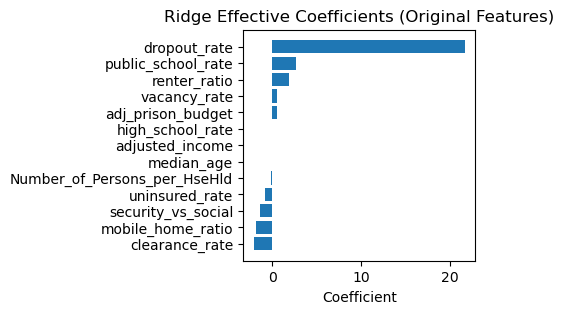

The top 4 important features in ridge are:
dropout_rate
public_school_rate
clearance_rate
mobile_home_ratio


In [277]:
key="dropna"
key1="Urban"
print(key+" "+key1+" model")

n_components = 8
alpha=20
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.002
threshold_removal=0.002
#Uncomment this to perform feature selection again
Best_features[(key,key1)]=list(Poly_feature_selection(set(X_train_dt[(key,key1)].columns), X_train_dt[(key,key1)], np.log(y_train_dt[(key,key1)]), models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,min_features=n_components))

ff=Best_features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models, models_stats, models_pred = log_fit(
    X_train_dt[(key,key1)][ff],X_test_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models)

# Using pretty table
print_table(models_stats)
feature_importance_PCA(fitted_models,ff,(3,3), plot=True, models_to_use=['ridge'])

Suburban Model

y=Ridge(features)

imputed Suburban model
Optimal subset of features:
19 ['poverty_rate adj_rehab_budget', 'Population unemployment_rate', 'poverty_rate adj_judiciary_budget', 'mobile_home_ratio vacancy_rate', 'vacancy_rate^2', 'mobile_home_ratio dropout_rate', 'uninsured_rate security_vs_social', 'adj_judiciary_budget house_affordability', 'poverty_rate', 'unemployment_rate adj_mental_health_budget', 'clearance_rate Number_of_Persons_per_HseHld', 'Population adj_welfare_budget', 'Population mobile_home_ratio', 'house_affordability high_school_rate', 'population_density poverty_rate', 'adj_health_budget security_vs_social', 'public_school_rate', 'adjusted_income median_age', 'uninsured_rate^2']
╔═══════╦══════════════╦════════════════════════╦═══════════════════════╦══════════════════════╦════════════════════╗
║ Model ║     Type     ║          MSE           ║          RMSE         ║       r2 Score       ║        MR2         ║
╠═══════╬══════════════╬════════════════════════╬═══════════════════════╬══════

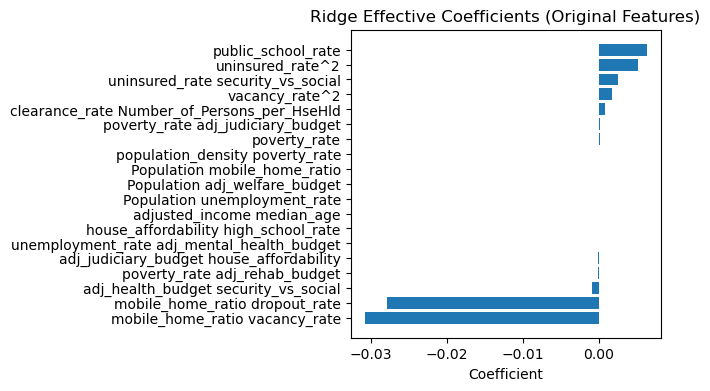

The top 4 important features in ridge are:
mobile_home_ratio vacancy_rate
mobile_home_ratio dropout_rate
public_school_rate
uninsured_rate^2


In [298]:
key="imputed"
key1="Suburban"
print(key+" "+key1+" model")

n_components = 5
alpha=50
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha=alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.002
threshold_removal=0.002
#Uncomment this to perform feature selection again
Best_features[(key,key1)]=['poverty_rate adj_rehab_budget', 'Population unemployment_rate', 'poverty_rate adj_judiciary_budget', 'mobile_home_ratio vacancy_rate', 'vacancy_rate^2', 'mobile_home_ratio dropout_rate', 'uninsured_rate security_vs_social', 'adj_judiciary_budget house_affordability', 'poverty_rate', 'unemployment_rate adj_mental_health_budget', 'clearance_rate Number_of_Persons_per_HseHld', 'Population adj_welfare_budget', 'Population mobile_home_ratio', 'house_affordability high_school_rate', 'population_density poverty_rate', 'adj_health_budget security_vs_social', 'public_school_rate', 'adjusted_income median_age', 'uninsured_rate^2']

ff=Best_features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models, models_stats, models_pred = deep_cross_fit1(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models
)

# Using pretty table
print_table(models_stats)
feature_importance_PCA(fitted_models,ff,(4,4), plot=True, models_to_use=['ridge'])

Rural model

We regress log(y) =Ridge(features)

i.e. y=exp(Ridge(features))

dropna Rural model
Processing block 0 to 25
Processing block 25 to 50
finished blocks
Optimal subset of features:
10 ['uninsured_rate', 'renter_ratio', 'adj_education_budget', 'median_age', 'security_vs_social', 'poverty_rate', 'adj_rehab_budget', 'mobile_home_ratio', 'clearance_rate', 'high_school_rate']
╔═══════╦══════════════╦════════════════════════╦═══════════════════════╦═════════════════════╦═════════════════════╗
║ Model ║     Type     ║          MSE           ║          RMSE         ║       r2 Score      ║         MR2         ║
╠═══════╬══════════════╬════════════════════════╬═══════════════════════╬═════════════════════╬═════════════════════╣
║ ridge ║  Reg train   ║ 2.443319769057261e-06  ║  0.001562636788091674 ║  0.3332563317516716 ║  0.3332563317516715 ║
║       ║   Reg val    ║ 2.666817789050808e-06  ║  0.001616012400013567 ║  0.2557590129011609 ║ 0.27712235731057866 ║
║       ║ County train ║ 2.414833592952966e-06  ║ 0.0015532743522845424 ║  0.3416786745037594 ║  0.3416

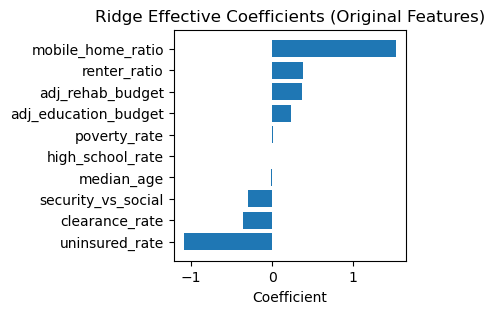

The top 4 important features in ridge are:
mobile_home_ratio
uninsured_rate
renter_ratio
adj_rehab_budget


In [284]:
key="dropna"
key1="Rural"
print(key+" "+key1+" model")

n_components = 7
alpha=100
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.002
threshold_removal=0.002
#Uncomment this to perform feature selection again
Best_features[(key,key1)]=list(Poly_feature_selection(set(X_train_dt[(key,key1)].columns), X_train_dt[(key,key1)], np.log(y_train_dt[(key,key1)]), models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,min_features=n_components))

ff=Best_features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models, models_stats, models_pred = log_fit(
    X_train_dt[(key,key1)][ff],X_test_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models)

# Using pretty table
print_table(models_stats)
feature_importance_PCA(fitted_models,ff,(3,3), plot=True, models_to_use=['ridge'])

dropna Rural model
Processing block 0 to 25
Processing block 25 to 50
Processing block 50 to 75
Processing block 75 to 100
Processing block 100 to 125
Processing block 125 to 150
Processing block 150 to 175
Processing block 175 to 200
Processing block 200 to 225
Processing block 225 to 250
Processing block 250 to 275
Processing block 275 to 300
Processing block 300 to 325
Processing block 325 to 350
Processing block 350 to 375
Processing block 375 to 400
Processing block 400 to 425
Processing block 425 to 450
finished blocks
Optimal subset of features:
17 ['home_ownership_rate uninsured_rate', 'dropout_rate', 'adj_education_budget adj_health_budget', 'adjusted_income social_vs_security', 'median_age uninsured_rate', 'adj_judiciary_budget adj_prison_budget', 'poverty_rate', 'clearance_rate', 'rent_burden dropout_rate', 'poverty_rate public_school_rate', 'clearance_rate high_school_rate', 'adj_rehab_budget adj_judiciary_budget', 'house_affordability', 'adj_health_budget uninsured_rate', 

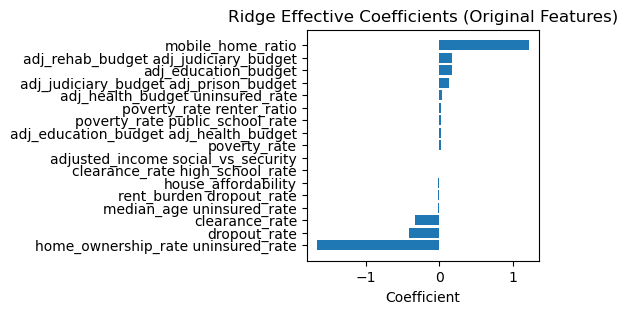

The top 4 important features in ridge are:
home_ownership_rate uninsured_rate
mobile_home_ratio
dropout_rate
clearance_rate


In [304]:
key="dropna"
key1="Rural"
print(key+" "+key1+" model")

n_components = 7
alpha=100
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.002
threshold_removal=0.002
#Uncomment this to perform feature selection again
Best_features[(key,key1)]=list(Poly_feature_selection(set(X_train_Poly_dt[(key,key1)].columns), X_train_Poly_dt[(key,key1)], np.log(y_train_dt[(key,key1)]), models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,min_features=n_components,dd=25))

ff=Best_features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models, models_stats, models_pred = log_fit(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models)

# Using pretty table
print_table(models_stats)
feature_importance_PCA(fitted_models,ff,(3,3), plot=True, models_to_use=['ridge'])

dropna Rural model
Processing block 0 to 25
Processing block 25 to 50
finished blocks
Optimal subset of features:
10 ['uninsured_rate', 'renter_ratio', 'adj_education_budget', 'median_age', 'security_vs_social', 'poverty_rate', 'adj_rehab_budget', 'mobile_home_ratio', 'clearance_rate', 'high_school_rate']
╔═══════╦══════════════╦════════════════════════╦═══════════════════════╦═════════════════════╦═════════════════════╗
║ Model ║     Type     ║          MSE           ║          RMSE         ║       r2 Score      ║         MR2         ║
╠═══════╬══════════════╬════════════════════════╬═══════════════════════╬═════════════════════╬═════════════════════╣
║ ridge ║  Reg train   ║ 2.443319769057261e-06  ║  0.001562636788091674 ║  0.3332563317516716 ║  0.3332563317516715 ║
║       ║   Reg val    ║ 2.666817789050808e-06  ║  0.001616012400013567 ║  0.2557590129011609 ║ 0.27712235731057866 ║
║       ║ County train ║ 2.414833592952966e-06  ║ 0.0015532743522845424 ║  0.3416786745037594 ║  0.3416

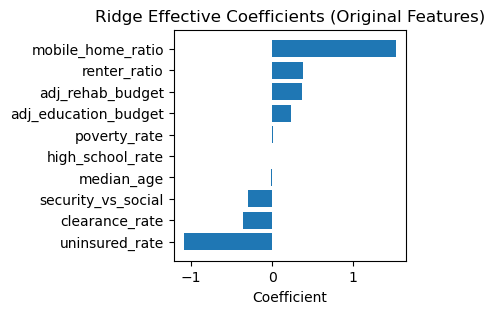

The top 4 important features in ridge are:
mobile_home_ratio
uninsured_rate
renter_ratio
adj_rehab_budget


In [305]:
key="dropna"
key1="Rural"
print(key+" "+key1+" model")

n_components = 7
alpha=100
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.002
threshold_removal=0.002
#Uncomment this to perform feature selection again
Best_features[(key,key1)]=list(Poly_feature_selection(set(X_train_dt[(key,key1)].columns), X_train_dt[(key,key1)], np.log(y_train_dt[(key,key1)]), models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,min_features=n_components,dd=25))

ff=Best_features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models, models_stats, models_pred = log_fit(
    X_train_dt[(key,key1)][ff],X_test_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models)

# Using pretty table
print_table(models_stats)
feature_importance_PCA(fitted_models,ff,(3,3), plot=True, models_to_use=['ridge'])

In [ ]:
# To save the dictionary
joblib.dump(Best_features, "best_features.pkl")

['best_features.pkl']

In [296]:
key="dropna"
for key1 in ["Urban","Suburban","Rural"]:
    cd=crime_dataframe
    cd=cd[cd['Category_'+key1]==1]
    print(key1)
    print(len(cd.index.get_level_values("County").unique())," counties")

Urban
14  counties
Suburban
17  counties
Rural
27  counties


# Unused, extra codes

In [ ]:
def Feature_selection(S, X, y, model, threshold_removal=0.005, threshold_addition=0.005):
    """
    Selects an optimal subset of features using a three-step DFS process:
      1) Removal: Remove features from S if doing so does not reduce MR2 by more than threshold_removal.
      2) Addition: From the originally removed features, DFS to add features back if they improve MR2 by at least threshold_addition.
      3) Final Removal: Run the removal process again on the augmented set using threshold_removal.
    
    Parameters:
      S : iterable
          The initial set (or list) of feature names.
      X : pd.DataFrame
          Training features with a MultiIndex (County, Year).
      y : pd.Series or pd.DataFrame
          Training target values.
      model : scikit-learn estimator
          The model to use for evaluation.
      threshold_removal : float, default=0.005
          The maximum permitted drop in average MR2 when removing a feature.
      threshold_addition : float, default=0.005
          The minimum increase in average MR2 required to add a new feature.
    
    Returns:
      set
          The final optimal subset of features.
    """
    # Convert S to a set
    S_initial = set(S)
    # Step 1: Removal phase
    S_removed = remove_features(S_initial, X, y, model, threshold=threshold_removal)
    # Determine the features that were removed
    removed_features = S_initial - S_removed
    # Step 2: Addition phase
    S_added = add_features(S_removed, removed_features, X, y, model, threshold=threshold_addition)
    # Step 3: Final removal phase
    S_final = remove_features(S_added, X, y, model, threshold=threshold_removal)
    return S_final



In [ ]:


def PCA_feature_selection(S, X, y, model, max_components=10):
    """
    Finds the optimal number of PCA components and optimal feature subset.
    
    For each n_components (starting at 1), it creates a pipeline:
         Pipeline([("scale", StandardScaler()), ("pca", PCA(n_components=n_components)), ("mod", model)])
    Then it calls Feature_selection(S, X, y, model_pipe) to select the best features
    and computes the average MR2 using leave-one-county-out CV (via compute_avg_MR2).
    
    It increases n_components by 1 until the average MR2 decreases; then, the previous
    setting is returned.
    
    Parameters:
      S : iterable
          The initial set of feature names.
      X : pd.DataFrame
          Training features with a MultiIndex (County, Year).
      y : pd.Series or pd.DataFrame
          Training target values.
      model : scikit-learn estimator
          The model to use (e.g., LinearRegression()).
      max_components : int, optional
          Maximum number of PCA components to try (default is 10).
    
    Returns:
      tuple: (best_n_components, best_feature_subset, best_avg_MR2)
    """
    best_mr2 = -np.inf
    best_n = None
    best_features = None
    
    # Loop over increasing PCA dimensions.
    for n in range(1, max_components + 1):
        # Create a pipeline with n_components in the PCA step.
        model_pipe = Pipeline([
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=n)),
            ("mod", model)
        ])
        
        # Run DFS-based feature selection with the current pipeline.
        selected_features = Feature_selection(S, X, y, model_pipe)
        # Compute average MR2 using leave-one-county-out CV.
        avg_mr2 = compute_avg_MR2(selected_features, X, y, model_pipe)
        print(f"n_components = {n}, selected features = {selected_features}, MR2 = {avg_mr2}")
        
        # If MR2 improves, update best values; if it drops, stop and return the previous best.
        if avg_mr2 > best_mr2:
            best_mr2 = avg_mr2
            best_n = n
            best_features = selected_features
        else:
            # MR2 has decreased; we assume the previous configuration was optimal.
            break
            
    return best_n, best_features#, best_mr2


In [ ]:
def feature_importance(fitted_models,features,size):
    coeffs_mlr = fitted_models["mlr"].named_steps["Lin"].coef_
    sorted_indices_mlr = np.argsort(coeffs_mlr)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_mlr], coeffs_mlr[sorted_indices_mlr])
    plt.title("Linear Regression Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(coeffs_mlr[i]),features[i]) for i in sorted_indices_mlr]
    ll.sort(reverse=True)
    print('The top 4 important features in mlr is')
    for xx in ll[:4]:
        print(xx[1])

    coeffs_ridge = fitted_models["ridge"].named_steps['ridge'].coef_
    sorted_indices_ridge = np.argsort(coeffs_ridge)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_ridge], coeffs_ridge[sorted_indices_ridge])
    plt.title("Ridge Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(coeffs_ridge[i]),features[i]) for i in sorted_indices_ridge]
    ll.sort(reverse=True)
    print('The top 4 important features in ridge is')
    for xx in ll[:4]:
        print(xx[1])

    importance_xgb = fitted_models["xgb"].feature_importances_
    sorted_indices_xgb = np.argsort(importance_xgb)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_xgb], importance_xgb[sorted_indices_xgb])
    plt.title("XGB Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(importance_xgb[i]),features[i]) for i in sorted_indices_xgb]
    ll.sort(reverse=True)
    print('The top 4 important features in xgb is')
    for xx in ll[:4]:
        print(xx[1])


    importance_randomforest = fitted_models["random_forest"].named_steps["randomforest"].feature_importances_
    sorted_indices_randomforest = np.argsort(importance_randomforest)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_randomforest], importance_randomforest[sorted_indices_randomforest])
    plt.title("RandomForest Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(importance_randomforest[i]),features[i]) for i in sorted_indices_randomforest]
    ll.sort(reverse=True)
    print('The top 4 important features in randomforest is')
    for xx in ll[:4]:
        print(xx[1])

# Linear models

In [20]:
fitted_models={}
models_stats={}
models_pred={}

# Uncomment this to perform feature selection again
#features={}

#Load selected features:
features = joblib.load("features.pkl")

Urban Models

In [25]:
key="imputed"
key1="Urban"
print(key+" "+key1+" model")

n_components = 5
alpha=100
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.0005
threshold_removal=0.002
#Uncomment this to perform feature selection again
#features[(key,key1)]=list(Poly_feature_selection(set(X_train_Poly_dt[(key,key1)].columns), X_train_Poly_dt[(key,key1)], y_train_dt[(key,key1)], models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal))

ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = deep_cross_fit1(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models
)

# Using pretty table
print_table(models_stats[(key,key1)])
feature_importance_PCA(fitted_models[(key,key1)],features[(key,key1)],(3,3), plot=False, models_to_use=['ridge'])

imputed Urban model
Optimal subset of features:
13 ['uninsured_rate^2', 'clearance_rate home_ownership_rate', 'home_ownership_rate', 'Population vacancy_rate', 'adjusted_income renter_ratio', 'adj_welfare_budget house_affordability', 'rent_burden median_age', 'unemployment_rate uninsured_rate', 'adj_prison_budget', 'clearance_rate public_school_rate', 'security_vs_social', 'unemployment_rate median_house_value', 'Population adj_rehab_budget']
╔═══════╦══════════════╦════════════════════════╦═══════════════════════╦══════════════════════╦════════════════════╗
║ Model ║     Type     ║          MSE           ║          RMSE         ║       r2 Score       ║        MR2         ║
╠═══════╬══════════════╬════════════════════════╬═══════════════════════╬══════════════════════╬════════════════════╣
║ ridge ║  Reg train   ║ 2.651116551922819e-06  ║ 0.0016267122211047695 ║  0.6976419989748679  ║ 0.6976419989748679 ║
║       ║   Reg val    ║ 2.7276884859081606e-06 ║  0.001633079666280068 ║  0.6930

In [26]:
key="dropna"
key1="Urban"
print(key+" "+key1+" model")

n_components = 5
alpha=30
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha=alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.0005
threshold_removal=0.002
#Uncomment this to perform feature selection again
#features[(key,key1)]=list(Poly_feature_selection(set(X_train_Poly_dt[(key,key1)].columns), X_train_Poly_dt[(key,key1)], y_train_dt[(key,key1)], models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,dd=35))

ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = deep_cross_fit1(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models
)

# Using pretty table
print_table(models_stats[(key,key1)])
feature_importance_PCA(fitted_models[(key,key1)],features[(key,key1)],(3,3), plot=False, models_to_use=['ridge'])

dropna Urban model
Optimal subset of features:
15 ['adjusted_income uninsured_rate', 'adjusted_income^2', 'dropout_rate', 'adjusted_income', 'rent_burden adj_judiciary_budget', 'mobile_home_ratio high_school_rate', 'home_ownership_rate adj_police_budget', 'median_age', 'clearance_rate poverty_rate', 'adj_prison_budget', 'median_age adj_judiciary_budget', 'security_vs_social', 'median_age^2', 'clearance_rate', 'unemployment_rate adj_police_budget']
╔═══════╦══════════════╦════════════════════════╦═══════════════════════╦═════════════════════╦════════════════════╗
║ Model ║     Type     ║          MSE           ║          RMSE         ║       r2 Score      ║        MR2         ║
╠═══════╬══════════════╬════════════════════════╬═══════════════════════╬═════════════════════╬════════════════════╣
║ ridge ║  Reg train   ║ 7.020646040085065e-07  ║ 0.0008374428616650357 ║  0.8092759078304479 ║ 0.8092759078304479 ║
║       ║   Reg val    ║ 7.849230281538913e-07  ║ 0.0008661888045140403 ║  0.785

Suburban models

In [ ]:
key="imputed"
key1="Suburban"
print(key+" "+key1+" model")

n_components = 5
alpha=30
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha=alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.0005
threshold_removal=0.002
#Uncomment this to perform feature selection again
features[(key,key1)]=['poverty_rate adj_rehab_budget', 'Population unemployment_rate', 'poverty_rate adj_judiciary_budget', 'mobile_home_ratio vacancy_rate', 'vacancy_rate^2', 'mobile_home_ratio dropout_rate', 'uninsured_rate security_vs_social', 'adj_judiciary_budget house_affordability', 'poverty_rate', 'unemployment_rate adj_mental_health_budget', 'clearance_rate Number_of_Persons_per_HseHld', 'Population adj_welfare_budget', 'Population mobile_home_ratio', 'house_affordability high_school_rate', 'population_density poverty_rate', 'adj_health_budget security_vs_social', 'public_school_rate', 'adjusted_income median_age', 'uninsured_rate^2']

ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = deep_cross_fit1(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models
)

# Using pretty table
print_table(models_stats[(key,key1)])

imputed Suburban model
Optimal subset of features:
18 ['unemployment_rate mobile_home_ratio', 'Population', 'mobile_home_ratio adj_welfare_budget', 'adj_education_budget social_vs_security', 'uninsured_rate', 'adjusted_income high_school_rate', 'rent_burden mobile_home_ratio', 'median_house_value', 'public_school_rate', 'adjusted_income^2', 'home_ownership_rate median_house_value', 'mobile_home_ratio', 'poverty_rate adj_police_budget', 'clearance_rate Number_of_Persons_per_HseHld', 'poverty_rate median_age', 'adjusted_income median_house_value', 'clearance_rate', 'population_density']
╔═══════╦══════════════╦════════════════════════╦═══════════════════════╦══════════════════════╦═════════════════════╗
║ Model ║     Type     ║          MSE           ║          RMSE         ║       r2 Score       ║         MR2         ║
╠═══════╬══════════════╬════════════════════════╬═══════════════════════╬══════════════════════╬═════════════════════╣
║ ridge ║  Reg train   ║ 1.5950361766145837e-06 ║  

In [24]:
key="dropna"
key1="Suburban"
print(key+" "+key1+" model")

n_components = 6
alpha=100
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha=alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.0005
threshold_removal=0.002
#Uncomment this to perform feature selection again
features[(key,key1)]=list(Poly_feature_selection(set(X_train_Poly_dt[(key,key1)].columns), X_train_Poly_dt[(key,key1)], y_train_dt[(key,key1)], models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,dd=35))

ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = deep_cross_fit1(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models
)

# Using pretty table
print_table(models_stats[(key,key1)])

dropna Suburban model
Processing block 0 to 35
Processing block 35 to 70
Processing block 70 to 105
Processing block 105 to 140
Processing block 140 to 175
Processing block 175 to 210
Processing block 210 to 245
Processing block 245 to 280
Processing block 280 to 315
Processing block 315 to 350
Processing block 350 to 385
Processing block 385 to 420
Processing block 420 to 455
Processing block 455 to 490
Optimal subset of features:
13 ['median_age adj_welfare_budget', 'adj_mental_health_budget public_school_rate', 'Population adj_mental_health_budget', 'mobile_home_ratio security_vs_social', 'Population^2', 'adj_police_budget dropout_rate', 'adjusted_income mobile_home_ratio', 'Population median_house_value', 'vacancy_rate adj_rehab_budget', 'clearance_rate adjusted_income', 'Number_of_Persons_per_HseHld adj_health_budget', 'vacancy_rate', 'mobile_home_ratio median_age']
╔═══════╦══════════════╦════════════════════════╦═══════════════════════╦═════════════════════╦═════════════════════

Rural models

In [112]:
key="imputed"
key1="Rural"
print(key+" "+key1+" model")

n_components = 5
alpha=100
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha=alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.0005
threshold_removal=0.002
#Uncomment this to perform feature selection again
#features[(key,key1)]=list(Poly_feature_selection(set(X_train_Poly_dt[(key,key1)].columns), X_train_Poly_dt[(key,key1)], y_train_dt[(key,key1)], models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,dd=35))

ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = deep_cross_fit1(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models
)

# Using pretty table
print_table(models_stats[(key,key1)])

imputed Rural model
Optimal subset of features:
16 ['adjusted_income public_school_rate', 'vacancy_rate', 'adj_rehab_budget', 'rent_burden social_vs_security', 'social_vs_security security_vs_social', 'adj_judiciary_budget public_school_rate', 'Population mobile_home_ratio', 'adj_education_budget^2', 'rent_burden uninsured_rate', 'adj_rehab_budget adj_prison_budget', 'rent_burden', 'population_density home_ownership_rate', 'population_density rent_burden', 'Number_of_Persons_per_HseHld', 'unemployment_rate median_house_value', 'poverty_rate']
╔═══════╦══════════════╦════════════════════════╦═══════════════════════╦══════════════════════╦══════════════════════╗
║ Model ║     Type     ║          MSE           ║          RMSE         ║       r2 Score       ║         MR2          ║
╠═══════╬══════════════╬════════════════════════╬═══════════════════════╬══════════════════════╬══════════════════════╣
║ ridge ║  Reg train   ║  4.81996363546391e-06  ║  0.002193668851644663 ║  0.26119942892213

In [113]:
key="dropna"
key1="Rural"
print(key+" "+key1+" model")

n_components = 5
alpha=100
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("ridge", Ridge(alpha=alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.0005
threshold_removal=0.002
#Uncomment this to perform feature selection again
#features[(key,key1)]=list(Poly_feature_selection(set(X_train_Poly_dt[(key,key1)].columns), X_train_Poly_dt[(key,key1)], y_train_dt[(key,key1)], models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal))

ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = deep_cross_fit1(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models
)

# Using pretty table
print_table(models_stats[(key,key1)])

dropna Rural model
Optimal subset of features:
21 ['Number_of_Persons_per_HseHld^2', 'clearance_rate house_affordability', 'renter_ratio^2', 'adjusted_income uninsured_rate', 'uninsured_rate security_vs_social', 'adjusted_income poverty_rate', 'uninsured_rate', 'mobile_home_ratio adj_prison_budget', 'mobile_home_ratio median_house_value', 'adj_judiciary_budget median_house_value', 'home_ownership_rate adj_judiciary_budget', 'adj_judiciary_budget public_school_rate', 'Population mobile_home_ratio', 'adj_education_budget^2', 'median_house_value', 'median_house_value security_vs_social', 'adjusted_income median_age', 'poverty_rate Number_of_Persons_per_HseHld', 'dropout_rate', 'adjusted_income mobile_home_ratio', 'Number_of_Persons_per_HseHld']
╔═══════╦══════════════╦════════════════════════╦═══════════════════════╦═════════════════════╦═════════════════════╗
║ Model ║     Type     ║          MSE           ║          RMSE         ║       r2 Score      ║         MR2         ║
╠═══════╬═══

In [114]:
# To save the dictionary
joblib.dump(features, "features.pkl")

# To load it later
#features = joblib.load("features.pkl")


['features.pkl']

In [99]:
for key1 in ["Urban","Suburban","Rural"]:
    for key in ["imputed","dropna"]:
        print('\n')
        print(key+" "+key1+" model")
        # Can set plot=True to visualize the feature importances
        # Can modify models_to_use to include/exclude specific models
        feature_importance_PCA(fitted_models[(key,key1)],features[(key,key1)],(3,3), plot=False, models_to_use=['ridge'])



imputed Urban model
The top 4 important features in ridge are:
uninsured_rate^2
home_ownership_rate
clearance_rate home_ownership_rate
security_vs_social


dropna Urban model
The top 4 important features in ridge are:
dropout_rate
clearance_rate
security_vs_social
home_ownership_rate adj_police_budget


imputed Suburban model
The top 4 important features in ridge are:
public_school_rate
uninsured_rate
mobile_home_ratio
adj_education_budget social_vs_security


dropna Suburban model
The top 4 important features in ridge are:
adj_rehab_budget adj_judiciary_budget
renter_ratio security_vs_social
security_vs_social
security_vs_social^2


imputed Rural model
The top 4 important features in ridge are:
social_vs_security security_vs_social
adj_rehab_budget
vacancy_rate
adj_education_budget^2


dropna Rural model
The top 4 important features in ridge are:
uninsured_rate security_vs_social
uninsured_rate
mobile_home_ratio adj_prison_budget
home_ownership_rate adj_judiciary_budget


# Models: log(y) =Ridge(features)

In [51]:
key="dropna"
key1="Urban"
print(key+" "+key1+" model")

n_components = 8
alpha=20
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.002
threshold_removal=0.002
#Uncomment this to perform feature selection again
ff=list(Poly_feature_selection(set(X_train_Poly_log_dt[(key,key1)].columns), X_train_Poly_log_dt[(key,key1)], np.log(y_train_dt[(key,key1)]), models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,min_features=n_components))

#ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = log_fit(
    X_train_Poly_log_dt[(key,key1)][ff],X_test_Poly_log_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models)

# Using pretty table
print_table(models_stats[(key,key1)])
feature_importance_PCA(fitted_models[(key,key1)],ff,(3,3), plot=False, models_to_use=['ridge'])

dropna Urban model
Processing block 0 to 25
Processing block 25 to 50
Processing block 50 to 75
Processing block 75 to 100
Processing block 100 to 125
Processing block 125 to 150
Processing block 150 to 175
Processing block 175 to 200
Processing block 200 to 225
Processing block 225 to 250
Processing block 250 to 275
Processing block 275 to 300
Processing block 300 to 325
Processing block 325 to 350
Processing block 350 to 375
Processing block 375 to 400
Processing block 400 to 425
Processing block 425 to 450
Processing block 450 to 475
Processing block 475 to 500
Processing block 500 to 525
Processing block 525 to 550
Processing block 550 to 575
Processing block 575 to 600
Processing block 600 to 625
Processing block 625 to 650
Processing block 650 to 675
Processing block 675 to 700
Processing block 700 to 725
Processing block 725 to 750
Processing block 750 to 775
Processing block 775 to 800
Processing block 800 to 825
Processing block 825 to 850
Processing block 850 to 875
Processin

In [ ]:
key="dropna"
key1="Suburban"
print(key+" "+key1+" model")

n_components = 7
alpha=150 #Maybe increase more
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.002
threshold_removal=0.002
#Uncomment this to perform feature selection again
ff=list(Poly_feature_selection(set(X_train_Poly_log_dt[(key,key1)].columns), X_train_Poly_log_dt[(key,key1)], np.log(y_train_dt[(key,key1)]), models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,min_features=n_components))

#ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = log_fit(
    X_train_Poly_log_dt[(key,key1)][ff],X_test_Poly_log_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models)

# Using pretty table
print_table(models_stats[(key,key1)])
feature_importance_PCA(fitted_models[(key,key1)],ff,(3,3), plot=False, models_to_use=['ridge'])

dropna Suburban model
Processing block 0 to 25
Processing block 25 to 50
Processing block 50 to 75
Processing block 75 to 100
Processing block 100 to 125
Processing block 125 to 150
Processing block 150 to 175
Processing block 175 to 200
Processing block 200 to 225
Processing block 225 to 250
Processing block 250 to 275
Processing block 275 to 300
Processing block 300 to 325
Processing block 325 to 350
Processing block 350 to 375
Processing block 375 to 400
Processing block 400 to 425
Processing block 425 to 450
Processing block 450 to 475
Processing block 475 to 500
Processing block 500 to 525
Processing block 525 to 550
Processing block 550 to 575
Processing block 575 to 600
Processing block 600 to 625
Processing block 625 to 650
Processing block 650 to 675
Processing block 675 to 700
Processing block 700 to 725
Processing block 725 to 750
Processing block 750 to 775
Processing block 775 to 800
Processing block 800 to 825
Processing block 825 to 850
Processing block 850 to 875
Proces

In [ ]:
key="dropna"
key1="Rural"
print(key+" "+key1+" model")

n_components = 7
alpha=20
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.002
threshold_removal=0.002
#Uncomment this to perform feature selection again
ff=list(Poly_feature_selection(set(X_train_Poly_log_dt[(key,key1)].columns), X_train_Poly_log_dt[(key,key1)], np.log(y_train_clean_dt[(key,key1)]), models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,min_features=n_components))

#ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = log_fit(
    X_train_Poly_log_dt[(key,key1)][ff],X_test_Poly_log_dt[(key,key1)][ff], y_train_clean_dt[(key,key1)],y_test_clean_dt[(key,key1)], **models)

# Using pretty table
print_table(models_stats[(key,key1)])
feature_importance_PCA(fitted_models[(key,key1)],ff,(3,3), plot=False, models_to_use=['ridge'])

dropna Rural model
Processing block 0 to 25
Processing block 25 to 50
Processing block 50 to 75
Processing block 75 to 100
Processing block 100 to 125
Processing block 125 to 150
Processing block 150 to 175
Processing block 175 to 200
Processing block 200 to 225
Processing block 225 to 250
Processing block 250 to 275
Processing block 275 to 300
Processing block 300 to 325
Processing block 325 to 350
Processing block 350 to 375
Processing block 375 to 400
Processing block 400 to 425
Processing block 425 to 450
Processing block 450 to 475
Processing block 475 to 500
Processing block 500 to 525
Processing block 525 to 550
Processing block 550 to 575
Processing block 575 to 600
Processing block 600 to 625
Processing block 625 to 650
Processing block 650 to 675
Processing block 675 to 700
Processing block 700 to 725
Processing block 725 to 750
Processing block 750 to 775
Processing block 775 to 800
Processing block 800 to 825
Processing block 825 to 850
Processing block 850 to 875
Processin

In [77]:
key="dropna"
key1="Rural"
print(key+" "+key1+" model")

for n_components in [5,6,7,8]:
    print("n_components",n_components)
    alpha=100
    print("alpha",alpha)
    models = {
        #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
        #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
        "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
        #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
    }

    threshold_addition=0.002
    threshold_removal=0.002
    #Uncomment this to perform feature selection again
    ff=list(Poly_feature_selection(set(X_train_Poly_log_dt[(key,key1)].columns), X_train_Poly_log_dt[(key,key1)], np.log(y_train_clean_dt[(key,key1)]), models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,min_features=n_components))

    #ff=features[(key,key1)]
    print("Optimal subset of features:")
    print(len(ff),ff)


    fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = log_fit(
        X_train_Poly_log_dt[(key,key1)][ff],X_test_Poly_log_dt[(key,key1)][ff], y_train_clean_dt[(key,key1)],y_test_clean_dt[(key,key1)], **models)

    # Using pretty table
    print_table(models_stats[(key,key1)])
    feature_importance_PCA(fitted_models[(key,key1)],ff,(3,3), plot=False, models_to_use=['ridge'])

dropna Rural model
n_components 5
alpha 100
Processing block 0 to 25
Processing block 25 to 50
Processing block 50 to 75
Processing block 75 to 100
Processing block 100 to 125
Processing block 125 to 150
Processing block 150 to 175
Processing block 175 to 200
Processing block 200 to 225
Processing block 225 to 250
Processing block 250 to 275
Processing block 275 to 300
Processing block 300 to 325
Processing block 325 to 350
Processing block 350 to 375
Processing block 375 to 400
Processing block 400 to 425
Processing block 425 to 450
Processing block 450 to 475
Processing block 475 to 500
Processing block 500 to 525
Processing block 525 to 550
Processing block 550 to 575
Processing block 575 to 600
Processing block 600 to 625
Processing block 625 to 650
Processing block 650 to 675
Processing block 675 to 700
Processing block 700 to 725
Processing block 725 to 750
Processing block 750 to 775
Processing block 775 to 800
Processing block 800 to 825
Processing block 825 to 850
Processing b

In [79]:
key="dropna"
key1="Rural"
print(key+" "+key1+" model")

for alpha in [70,100,130,160]:
    n_components=7
    print("n_components",n_components)
    print("alpha",alpha)
    models = {
        #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
        #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
        "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
        #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
    }

    threshold_addition=0.002
    threshold_removal=0.002
    #Uncomment this to perform feature selection again
    ff=list(Poly_feature_selection(set(X_train_Poly_log_dt[(key,key1)].columns), X_train_Poly_log_dt[(key,key1)], np.log(y_train_clean_dt[(key,key1)]), models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,dd=25,min_features=n_components))

    #ff=features[(key,key1)]
    print("Optimal subset of features:")
    print(len(ff),ff)


    fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = log_fit(
        X_train_Poly_log_dt[(key,key1)][ff],X_test_Poly_log_dt[(key,key1)][ff], y_train_clean_dt[(key,key1)],y_test_clean_dt[(key,key1)], **models)

    # Using pretty table
    print_table(models_stats[(key,key1)])
    feature_importance_PCA(fitted_models[(key,key1)],ff,(3,3), plot=False, models_to_use=['ridge'])

dropna Rural model
n_components 7
alpha 70
Processing block 0 to 25
Processing block 25 to 50
Processing block 50 to 75
Processing block 75 to 100
Processing block 100 to 125
Processing block 125 to 150
Processing block 150 to 175
Processing block 175 to 200
Processing block 200 to 225
Processing block 225 to 250
Processing block 250 to 275
Processing block 275 to 300
Processing block 300 to 325
Processing block 325 to 350
Processing block 350 to 375
Processing block 375 to 400
Processing block 400 to 425
Processing block 425 to 450
Processing block 450 to 475
Processing block 475 to 500
Processing block 500 to 525
Processing block 525 to 550
Processing block 550 to 575
Processing block 575 to 600
Processing block 600 to 625
Processing block 625 to 650
Processing block 650 to 675
Processing block 675 to 700
Processing block 700 to 725
Processing block 725 to 750
Processing block 750 to 775
Processing block 775 to 800
Processing block 800 to 825
Processing block 825 to 850
Processing bl

In [63]:
key="dropna"
key1="Suburban"
print(key+" "+key1+" model")

for alpha in [130,140,150,160,170,180,190,200]:
    n_components=7
    print("n_components",n_components)
    print("alpha",alpha)
    models = {
        #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
        #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
        "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
        #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
    }

    threshold_addition=0.002
    threshold_removal=0.002
    #Uncomment this to perform feature selection again
    ff=list(Poly_feature_selection(set(X_train_Poly_log_dt[(key,key1)].columns), X_train_Poly_log_dt[(key,key1)], np.log(y_train_dt[(key,key1)]), models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,dd=50,min_features=n_components))

    #ff=features[(key,key1)]
    print("Optimal subset of features:")
    print(len(ff),ff)


    fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = log_fit(
        X_train_Poly_log_dt[(key,key1)][ff],X_test_Poly_log_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models)

    # Using pretty table
    print_table(models_stats[(key,key1)])
    feature_importance_PCA(fitted_models[(key,key1)],ff,(3,3), plot=False, models_to_use=['ridge'])

dropna Suburban model
n_components 7
alpha 130
Processing block 0 to 50
Processing block 50 to 100
Processing block 100 to 150
Processing block 150 to 200
Processing block 200 to 250
Processing block 250 to 300
Processing block 300 to 350
Processing block 350 to 400
Processing block 400 to 450
Processing block 450 to 500
Processing block 500 to 550
Processing block 550 to 600
Processing block 600 to 650
Processing block 650 to 700
Processing block 700 to 750
Processing block 750 to 800
Processing block 800 to 850
Processing block 850 to 900
Processing block 900 to 950
Processing block 950 to 1000
Processing block 1000 to 1050
Processing block 1050 to 1100
Processing block 1100 to 1150
Processing block 1150 to 1200
Processing block 1200 to 1250
Processing block 1250 to 1300
Processing block 1300 to 1350
Processing block 1350 to 1400
Processing block 1400 to 1450
Processing block 1450 to 1500
Processing block 1500 to 1550
Processing block 1550 to 1600
Processing block 1600 to 1650
Proces

KeyboardInterrupt: 